In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import timm
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as F
from torch import nn

from src.notebooks_utils import get_data, get_adv_examples, show_grid
from src.adv_resnet import resnet50, EightBN
from src.imagenet_labels import IMAGENET_LABELS
from src.utils import normalize_model

In [4]:
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False

In [5]:
plt.rcParams["savefig.bbox"] = 'tight'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
output_dir = Path("outputs") / "attack"

In [6]:
# Set up model
CHECKPOINTS_DIR = "../checkpoints"

xcit_checkpoint_file = "xcit-imagenet-4.pth.tar"
xcit_model_name = "xcit_small_12_p16_224"
xcit = timm.create_model(xcit_model_name, checkpoint_path=os.path.join(CHECKPOINTS_DIR, xcit_checkpoint_file))
xcit = xcit.to(device)
xcit.eval()

resnet_checkpoint_file = "advres50_gelu.pth"
resnet = resnet50(norm_layer=EightBN)
resnet.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, resnet_checkpoint_file))["model"])
resnet = normalize_model(resnet, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
resnet = resnet.to(device)
resnet.eval()

benign_xcit = timm.create_model(xcit_model_name, pretrained=True)
benign_xcit = normalize_model(benign_xcit, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
benign_xcit = benign_xcit.to(device)
benign_xcit.eval();

In [7]:
main_paper_config = {
    "ex_to_show": 4,
    "ncols": 4,
    "axes_pad": 1.5,
    "seed": 0,
    "suffix": ""
}

appendix_config = {
    "ex_to_show": 16,
    "ncols": 8,
    "axes_pad": 0.2,
    "seed": 42,
    "suffix": "_appendix"
}

n_examples = 16
config = appendix_config

In [8]:
xcit_x, xcit_x_adv, xcit_y = get_adv_examples(xcit, device, n_examples, seed=config["seed"])

In [9]:
benign_xcit_x, benign_xcit_x_adv, benign_xcit_y = get_adv_examples(benign_xcit, device, n_examples, seed=config["seed"])

In [10]:
resnet_x, resnet_x_adv, resnet_y = get_adv_examples(resnet, device, n_examples, seed=config["seed"])

In [11]:
assert torch.all(resnet_y == xcit_y)

xcit_perts = xcit_x - xcit_x_adv
norm_xcit_perts = (xcit_perts + xcit_perts.max()) / (xcit_perts.max() * 2)

benign_xcit_perts = benign_xcit_x - benign_xcit_x_adv
norm_benign_xcit_perts = (benign_xcit_perts + benign_xcit_perts.max()) / (benign_xcit_perts.max() * 2)

resnet_perts = resnet_x - resnet_x_adv
norm_resnet_perts = (resnet_perts + resnet_perts.max()) / (resnet_perts.max() * 2)

In [12]:
labels = [IMAGENET_LABELS[l] for l in xcit_y[:config["ex_to_show"]]]
print(", ".join(labels))

Lhasa Apso, oxygen mask, maze, dugong, flatworm, salt shaker, macaw, horizontal bar, vulture, plectrum, knee pad, shoal, white-headed capuchin, bolete, impala, worm snake


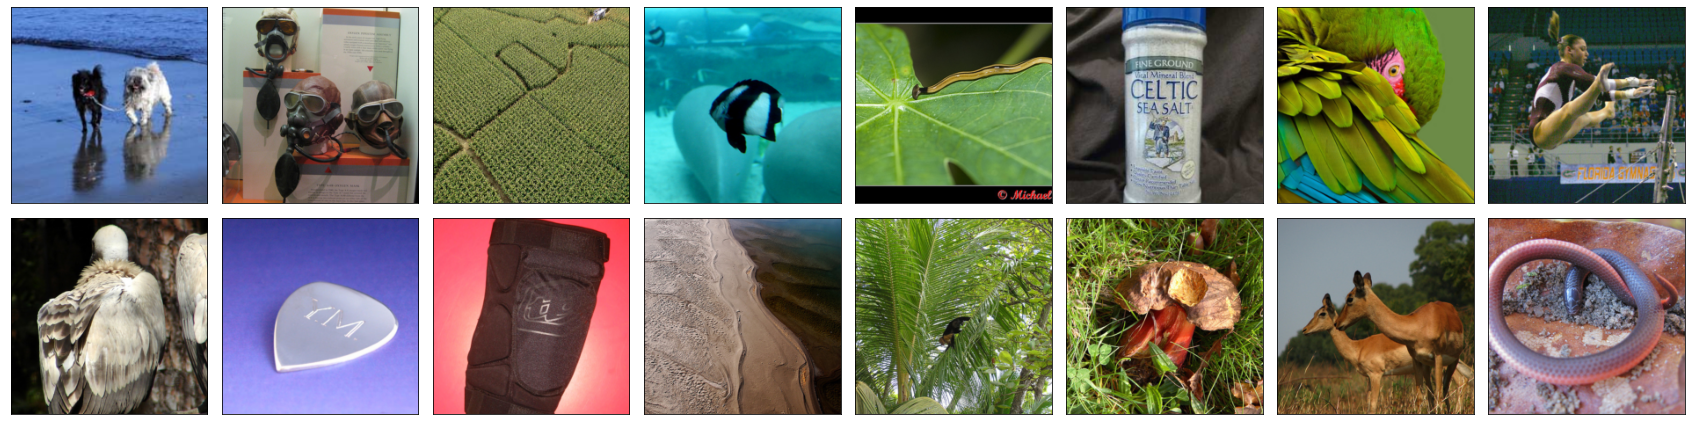

In [13]:
show_grid(xcit_x[:config["ex_to_show"]],
          filename=output_dir / f"original{config['suffix']}.png",
          ncols=config["ncols"],
          axes_pad=config["axes_pad"])

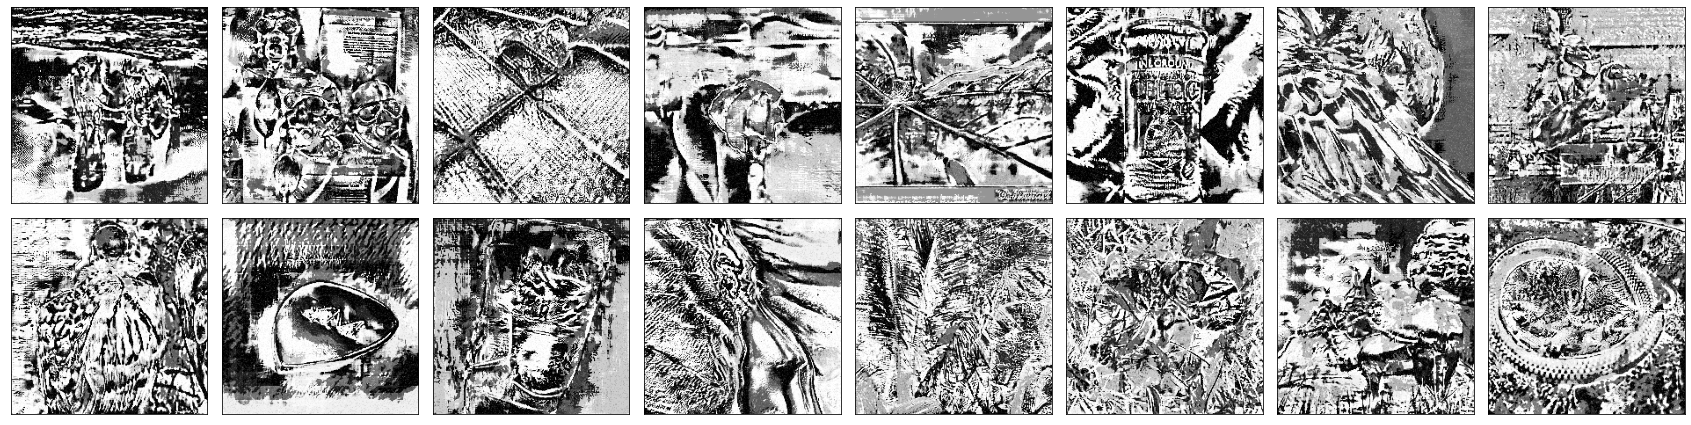

In [14]:
show_grid(F.rgb_to_grayscale(norm_xcit_perts[:config["ex_to_show"]]),
          cmap="Greys", filename=output_dir / f"xcit_robust{config['suffix']}.png",
          ncols=config["ncols"],
          axes_pad=config["axes_pad"])

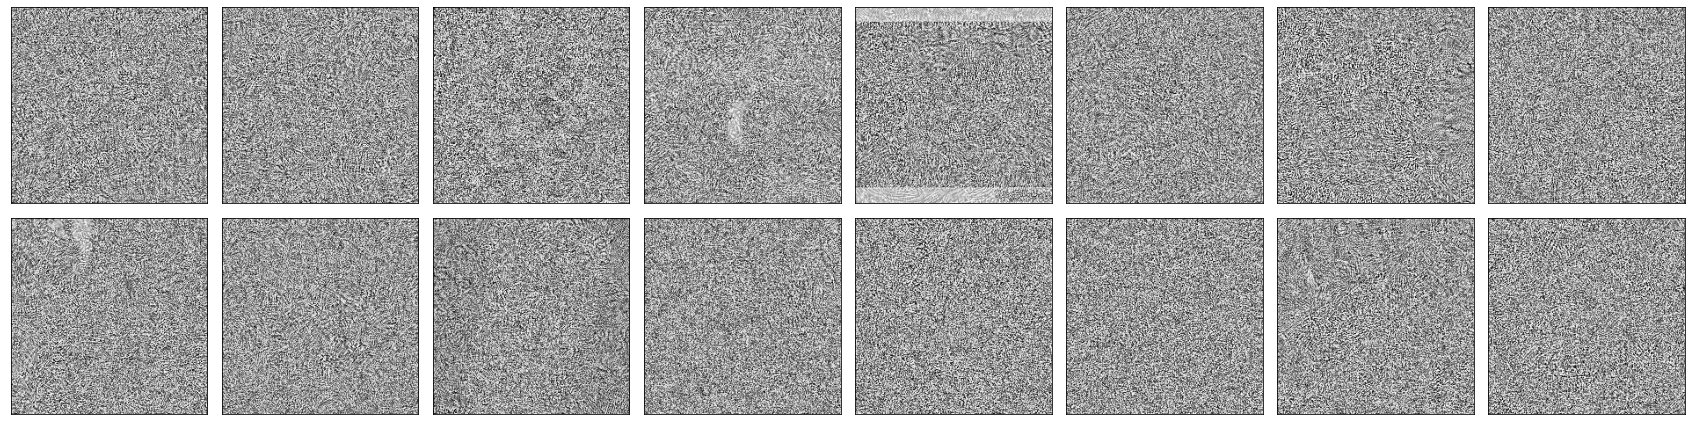

In [15]:
show_grid(F.rgb_to_grayscale(norm_benign_xcit_perts[:config["ex_to_show"]]),
          cmap="Greys", filename=output_dir / f"xcit_benign{config['suffix']}.png",
          ncols=config["ncols"],
          axes_pad=config["axes_pad"])

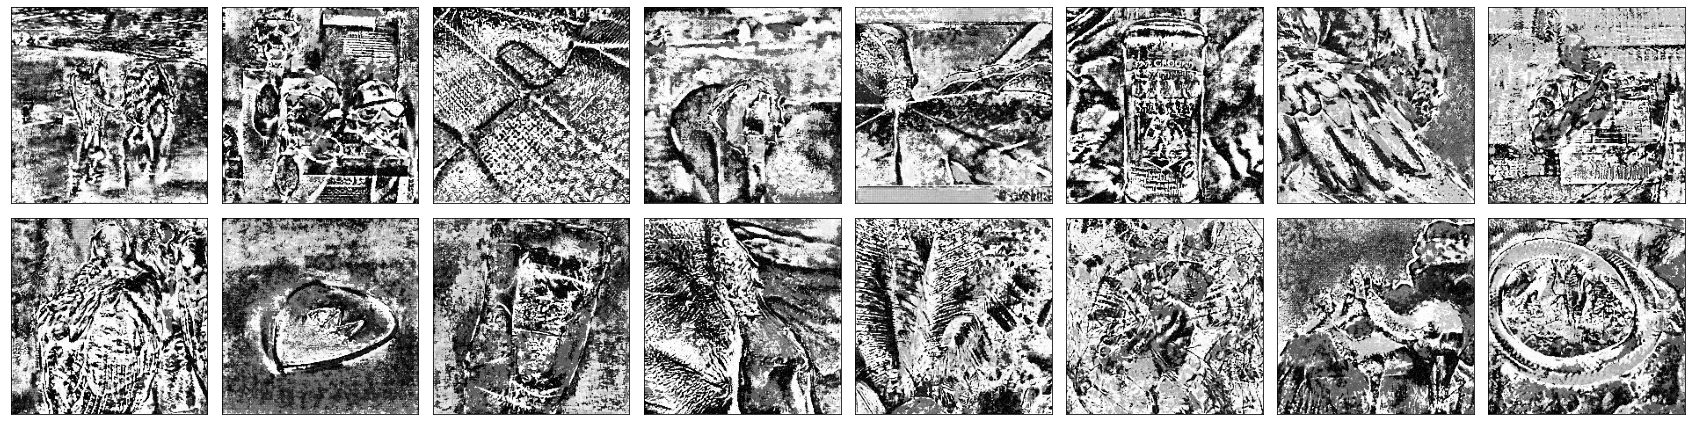

In [16]:
show_grid(F.rgb_to_grayscale(norm_resnet_perts[:config["ex_to_show"]]),
          cmap='Greys',
          filename=output_dir / f"resnet{config['suffix']}.png",
          ncols=config["ncols"],
          axes_pad=config["axes_pad"])